## Step 1: Problem Framing and Dataset Overview

### Objective
The goal of this recommender system is to **maximize the click-through rate (CTR)** on recommended items. CTR is chosen as the primary objective because clicks are abundant and serve as an early indicator of user interest, enabling effective offline evaluation and iterative model improvement.

### Evaluation Metrics
- **Candidate Generation Stage:**  
  - *Recall@100* — Measures the proportion of relevant items included in the candidate set. High recall ensures that the ranking stage has a rich pool of candidates.
- **Ranking Stage:**  
  - *NDCG@10* (Normalized Discounted Cumulative Gain) — Evaluates the quality and ordering of the top 10 recommended items, rewarding placing highly relevant items near the top.  
  - *Precision@10* — Measures the fraction of relevant items in the top 10 recommendations.
- **Business Proxy:**  
  - *Click-Through Rate (CTR)* — Used as a proxy for user engagement and business impact during online simulations or deployment.

### Personalization Strategy
- Focus on **session-based personalization**, leveraging recent user interactions within the current session to tailor recommendations dynamically.
- Incorporate **long-term user behavior features** (aggregated historical data) where available, to enhance personalization and ranking quality.

---

### Dataset Overview

The dataset contains three main files:

- **Events data (`events.csv`)**  
  Logs of user interactions on the site, including three event types:  
  - `view` (clicks)  
  - `addtocart`  
  - `transaction` (purchases)  
  This file has ~2.75 million events from over 1.4 million unique visitors.

- **Item properties (`item_properties.csv`)**  
  Contains metadata for items, including changing properties over time (e.g., price, category). The dataset has over 20 million rows across two files and tracks weekly snapshots.

- **Category tree (`category_tree.csv`)**  
  Defines the hierarchical relationship between item categories.

---

### Problem Definition

- **Primary problem:** Build a recommender system that predicts items a user is likely to interact with (especially clicks) to maximize CTR.
- **Secondary problems:**  
  - Predict item properties associated with "addtocart" events using data from "view" events.  
  - Identify and remove abnormal users to reduce noise and bias in recommendation quality.

---

This problem framing sets the foundation for subsequent steps including data preprocessing, feature engineering, modeling, evaluation, and deployment.


# Step 2: Exploratory Data Analysis

We conducted an exploratory analysis to better understand the dataset's structure, contents, and potential challenges before building the recommender system.


Loading datasets...

Datasets loaded successfully!

--- Dataset Shapes ---
Events: (2756101, 5)
Item Properties Part 1: (10999999, 4)
Item Properties Part 2: (9275903, 4)
Category Tree: (1669, 2)

--- Events Sample ---
       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN

--- Item Properties Part 1 Sample ---
       timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917             

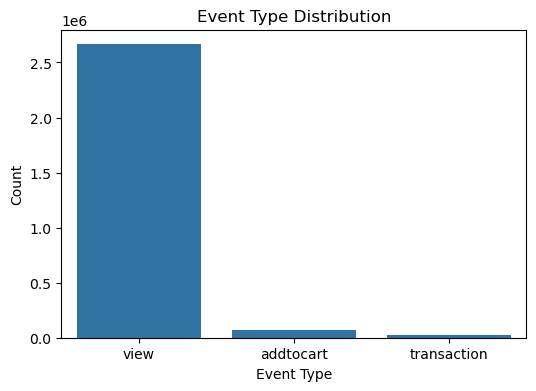


--- Event Timestamp Range ---
Min Timestamp: 1430622004384
Max Timestamp: 1442545187788

--- Converted Datetime Sample ---
       timestamp                datetime
0  1433221332117 2015-06-02 05:02:12.117
1  1433224214164 2015-06-02 05:50:14.164
2  1433221999827 2015-06-02 05:13:19.827
3  1433221955914 2015-06-02 05:12:35.914
4  1433221337106 2015-06-02 05:02:17.106

--- Events Per Day ---
datetime
2015-05-03    13683
2015-05-04    19414
2015-05-05    23015
2015-05-06    23920
2015-05-07    23164
dtype: int64


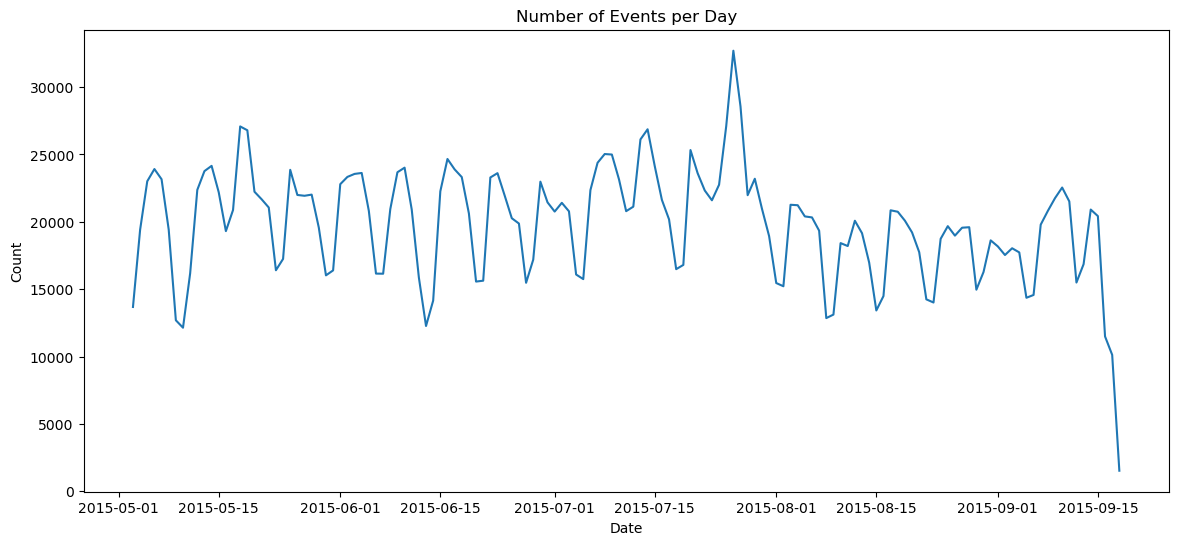


--- Top 10 Most Interacted Items ---
itemid
187946    3412
461686    2978
5411      2334
370653    1854
219512    1800
257040    1647
298009    1642
96924     1633
309778    1628
384302    1608
Name: count, dtype: int64


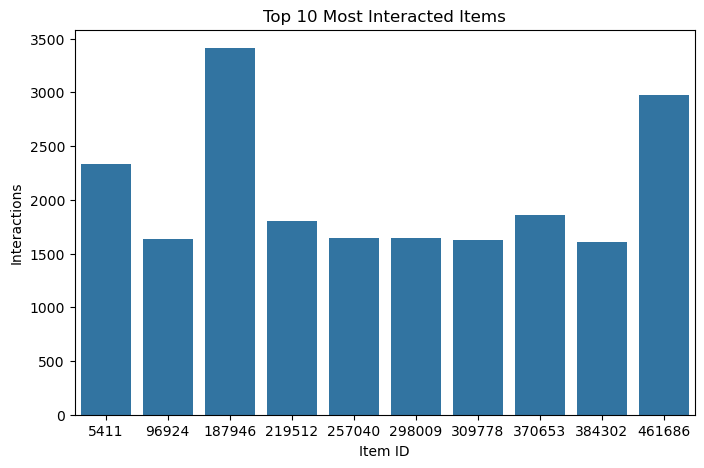


--- Adding Weekday and Hour Columns ---
                 datetime  weekday  hour
0 2015-06-02 05:02:12.117  Tuesday     5
1 2015-06-02 05:50:14.164  Tuesday     5
2 2015-06-02 05:13:19.827  Tuesday     5
3 2015-06-02 05:12:35.914  Tuesday     5
4 2015-06-02 05:02:17.106  Tuesday     5


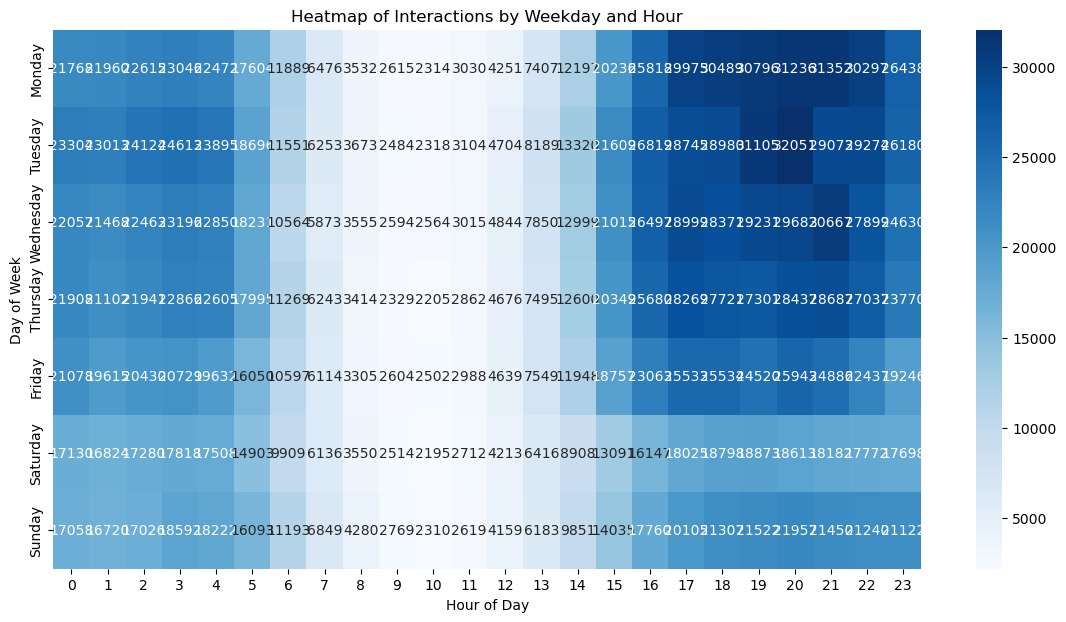

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File paths (relative to notebooks directory)
events_path = "../data/raw/retailrocket_events.csv.gz"
item_properties_part1_path = "../data/raw/item_properties_part1.csv"
item_properties_part2_path = "../data/raw/item_properties_part2.csv"
category_tree_path = "../data/raw/category_tree.csv"

# Load datasets
print("\nLoading datasets...")
events = pd.read_csv(events_path, compression="gzip")
item_properties_part1 = pd.read_csv(item_properties_part1_path)
item_properties_part2 = pd.read_csv(item_properties_part2_path)
category_tree = pd.read_csv(category_tree_path)

print("\nDatasets loaded successfully!")

# Dataset shapes
print("\n--- Dataset Shapes ---")
print(f"Events: {events.shape}")
print(f"Item Properties Part 1: {item_properties_part1.shape}")
print(f"Item Properties Part 2: {item_properties_part2.shape}")
print(f"Category Tree: {category_tree.shape}")

# Preview datasets
print("\n--- Events Sample ---")
print(events.head())

print("\n--- Item Properties Part 1 Sample ---")
print(item_properties_part1.head())

print("\n--- Item Properties Part 2 Sample ---")
print(item_properties_part2.head())

print("\n--- Category Tree Sample ---")
print(category_tree.head())

# Missing values
print("\n--- Missing Values ---")
print("Events:\n", events.isnull().sum())
print("\nItem Properties Part 1:\n", item_properties_part1.isnull().sum())
print("\nItem Properties Part 2:\n", item_properties_part2.isnull().sum())
print("\nCategory Tree:\n", category_tree.isnull().sum())

# Unique values in events
print("\n--- Unique Values in Events ---")
print(events.nunique())

# Event types distribution
print("\n--- Event Types Distribution ---")
print(events['event'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x="event", data=events, order=events['event'].value_counts().index)
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

# Time range of events
print("\n--- Event Timestamp Range ---")
print(f"Min Timestamp: {events['timestamp'].min()}")
print(f"Max Timestamp: {events['timestamp'].max()}")

# Convert timestamp to datetime for analysis
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')
print("\n--- Converted Datetime Sample ---")
print(events[['timestamp', 'datetime']].head())

# Events per day
events_per_day = events.groupby(events['datetime'].dt.date).size()
print("\n--- Events Per Day ---")
print(events_per_day.head())

plt.figure(figsize=(14,6))
events_per_day.plot()
plt.title("Number of Events per Day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

# Top 10 most interacted items
top_items = events['itemid'].value_counts().head(10)
print("\n--- Top 10 Most Interacted Items ---")
print(top_items)

plt.figure(figsize=(8,5))
sns.barplot(x=top_items.index, y=top_items.values)
plt.title("Top 10 Most Interacted Items")
plt.xlabel("Item ID")
plt.ylabel("Interactions")
plt.show()

# Event distribution by weekday/hour
print("\n--- Adding Weekday and Hour Columns ---")
events['weekday'] = events['datetime'].dt.day_name()
events['hour'] = events['datetime'].dt.hour
print(events[['datetime', 'weekday', 'hour']].head())

heatmap_data = events.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days, fill_value=0)

plt.figure(figsize=(14,7))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d')
plt.title("Heatmap of Interactions by Weekday and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()
